In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False

순환 신경망(Recurrent Neural Network, RNN)

순환 신경망은 시퀀스(sequence) 데이터를 사용한다. 시퀀스 데이터는 다른 말로 시계열(time serise) 데이터라고도 말하며, 시점에 따라서 데이터가 달라지는 것을 의미한다. 즉, 특정 시점에서 데이터를 한 번에 수집하는 것이 아닌 시간의 흐름에 따라 데이터를 점차 수집하는 것을 의미한다. 전체 데이터셋을 구성하는 각 데이터 포인트의 수집 시점이 다르다.

지금까지 다룬 신경망은 입력 데이터를 사용한 후 그 결과가 다시 입력층으로 돌아가지 않았다. 즉, 한 번 출력된 결과를 다시 사용되지 않았다. 이를 피드포워드(feedforward) 신경망이라 한다. 반면에 순환 신경망은 출력된 결과가 다음 시점에서 사용된다. 즉, 출력 결과를 다음 시점까지 기억했다가 사용하는 방식이다.

<img src="./images/rnn_1.png/" width="700"/>

LSTM(Long Short Term Memory)

순환 신경망은 은닉층을 거친 결과값을 재사용하는 특징이 있다. 그러나 그로 인해서 기울기 소멸 문제(vanishing gradient problem)나 기울기 폭주 문제(exploding gradient problem)가 발생할 수 있다. 기울기 소멸 문제는 학습이 진행되는 과정에서 기울기 점점 줄어들어 사라지는 현상을 의미하고 기울기 폭주는 학습 과정에서 기울기가 점점 커져서 폭주하는 현상을 말한다.

LSTM은 기울기 소멸이나 폭주 문제를 해결하기 위해 만든 방법이다. LSTM에서는 결과값이 다음 시점으로 넘어갈 때 결과값을 넘길지 말지 결정하는 단계가 추가된다.

<img src="./images/rnn_2.png/" width="800"/>

순환 신경망 실습  
순환 신경망을 이용해 영화 리뷰 감성 분석을 해본다.

In [2]:
# 일관된 결과값이 나오도록 random seed를 설정한다.
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

IMDB Movie Review Sentiment Analysis  
감성 분류를 연습하기 위해 자주 사용하는 영어 데이터로 영화 사이트 IMBD 리뷰 데이터가 있다.  
이 데이터는 리뷰에 대한 텍스트와 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성된 데이터로 스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 논문에서는 이 데이터를 훈련 데이터와 테스트 데이터를 50:50 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하고 있다.

In [3]:
# 데이터 불러오기
from tensorflow.keras import datasets # 텐서플로우가 제공하는 데이터셋을 사용하기 위해 import 한다.
# imdb 영화 리뷰 데이터는 트레이닝 데이터와 테스트 데이터가 나눠서 저장되어 있다.
# load_data() 메소드는 (트레이닝 피쳐 데이터, 트레이닝 타겟 데이터)와 (테스트 피쳐 데이터, 테스트 타겟 데이터)를
# 튜플 형태로 묶어서 리턴한다.
# num_words 속성을 사용해서 이 데이터에서 등장 빈도 순위로 몇 등까지의 단어를 사용할 것인지 지정한다.
# 예를 들어서 10000을 넣으면 등장 빈도 순위가 1 ~ 10000에 해당되는 단어만 사용하게 된다.
(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words=2000) # 영화 리뷰 데이터셋을 피쳐, 타겟 데이터로 저장한다.

In [4]:
# 오리지널 데이터 확인
# 트레이닝 피쳐 데이터, 트레이닝 타겟 데이터, 테스트 피쳐 데이터, 테스트 타겟 데이터 모두 25,000개의 
# 벡터 데이터로 구성되어 있음을 알 수 있다.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [5]:
# 트레이닝 데이터를 트레이닝 데이터셋과 벨리데이션 데이터셋으로 분리
# 25,000개의 트레이닝 데이터 중에서 5,000개의 트레이닝 데이터를 벨리데이션 데이터로 따로 저장한다.
X_tr = X_train[:20000] # 트레이닝 피쳐 데이터 25,000개 중에서 학습에 사용할 데이터 20,000개
X_valid = X_train[20000:] # 트레이닝 피쳐 데이터 25,000개 중에서 검증에 사용할 데이터 5,000개
y_tr = y_train[:20000] # 테스트 피쳐 데이터 25,000개 중에서 학습에 사용할 데이터 20,000개
y_valid = y_train[20000:] # 테스트 피쳐 데이터 25,000개 중에서 검증에 사용할 데이터 5,000개
print(X_tr.shape, X_valid.shape, y_tr.shape, y_valid.shape)

(20000,) (5000,) (20000,) (5000,)


In [6]:
# 데이터 형태 확인
# 트레이닝 피쳐 데이터 값을 확인해보면 숫자로 이루어진 리스트라는 것을 알 수 있다.
# 이는 오리지널 데이터에 이미 단어를 숫자 매핑해 놓아 영어 단어가 해당하는 숫자로 변환된 것임을 알 수 있다.
print(X_tr[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [7]:
# 개별 피쳐 데이터 크기 확인
# 피쳐 데이터의 가장 처음에 나오는 두 개의 피쳐값을 확인해 본 결과 문장의 길이가 다르다는 것을 의미하며
# RNN은 항상 같은 길이의 시퀀스를 받아야 하므로 나중에 같은 크기로 조정이 필요하다.
print(len(X_tr[0]))
print(len(X_tr[1]))

218
189


In [8]:
# 타겟 클래스 확인
# 타겟 클래스 구분은 0과 1로 2개로 이루어진 이진 분류 문제임을 확인할 수 있다.
print(set(y_train), set(y_test))

{0, 1} {0, 1}


In [9]:
# 피쳐 데이터 변형
# RNN은 항상 같은 길이의 시퀀스를 받아야 하기 때문에 제각기 다른 피쳐 데이터 값의 길이를 일치시킨다.
from tensorflow.keras.preprocessing import sequence # 피쳐 데이터 값의 길이를 일치시키기 위해 import 한다.
# pad_sequences() 메소드로 피쳐 데이터 값의 길이를 일치시킨다. maxlen 속성으로 길이를 지정할 수 있다.
# 길이를 지정하지 않으면 가장 큰 길이가 기본값으로 사용되고 길이를 맞추고 남는 부분에는 0이 패딩으로 채워진다.
# 길이를 지정하면 지정한 길이 만큼만 저장되고 나머지는 삭제된다.
X_tr = sequence.pad_sequences(X_tr, maxlen=100)
X_valid = sequence.pad_sequences(X_valid, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)
print(X_tr.shape, X_valid.shape, X_test.shape)

(20000, 100) (5000, 100) (25000, 100)


LSTM 신경망 모델을 만든다.

In [10]:
# 시퀀스 API를 사용한 LSTM 신경망 모델 생성에 필요한 라이브러리 import
from tensorflow.keras.models import Sequential # 시퀀스 API 신경망을 생성하기 위해 import 한다.
from tensorflow.keras.layers import Dense # 신경망에 추가할 완전 연결 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import Conv1D # 신경망에 추가할 합성곱 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import MaxPool1D # 신경망에 추가할 맥스 풀링 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import Dropout # 신경망에 추가할 드롭다운 layer를 생성하기 위해 import 한다.
# 임베딩이란 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자의 나열인 벡터로 바꾼 결과 혹은 전체 과정을 의미한다.
# 임베딩의 가장 간단한 형티는 단어의 빈도를 그대로 벡터로 사용하는 것이다.
from tensorflow.keras.layers import Embedding # 신경망에 추가할 임베딩 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import LSTM # 신경망에 추가할 LSTM layer를 생성하기 위해 import 한다.

In [11]:
# Sequential 객체를 선언 후 Sequential 모델에 add() 메소드로 layer를 추가해서 쌓아올린다.
model = Sequential() # 신경망(RNN) 모델을 만든다.

# 신경망 모델에 Embedding layer를 추가한다.
# 총 2,000개의 단어를 사용하므로 input_dim 속성은 2,000을 지정하고 데이터 길이는 100개로 맞췄으므로
# output_dim 속성은 100을 지정한다.
# Embedding layer의 Output Shape은 poutput_dim의 크기로 결정된다. (None, None, 100)
# Param은 input_dim * output_dim으로 결정된다. 2000 * 100 = 200000
model.add(Embedding(input_dim=2000, output_dim=100))

# CNN은 2차원 데이터를 이용해서 Conv2D layer를 사용했지만 LSTM은 1차원 데이터가 입력되므로 Conv1D layer를
# 사용한다.
# 신경망 모델에 Conv1D layer를 추가한다.
# filters 속성으로 Conv1D layer를 거쳐서 출력되는 데이터의 차원을 지정한다.
# kernel_size 속성으로 커널의 크기를 지정하는데 Conv2D layer는 2차원 데이터를 이용하므로 커널 크기도 
# 2차원으로 지정하고 Conv1D layer는 1차원 데이터를 이용하므로 커널 크기를 1차원으로 지정한다.
# padding 속성으로 패딩 방법을 지정한다. valid(기본값)은 패딩을 사용하지 않고 same은 패딩을 사용한다.
# activation 속성으로 활성화 함수를 지정한다.
# Conv1D layer의 Output Shape은 filters의 크기로 결정된다. (None, None, 50)
# Conv1D layer의 Param은 kernel_size * 입력 채널 크기 * filters + filters마다 1개씩의 바이어스로 결정된다.
# kernel_size(3) * 입력 채널 크기(100) * filters(50) + filters마다 1개씩의 바이어스(50) = 15050
model.add(Conv1D(filters=50, kernel_size=3, padding='valid', activation='relu'))

# 신경망 모델에 MaxPool layer를 추가한다.
# pool_size 속성으로 맥스 풀링을 실행할 크기를 지정한다.
# MaxPool1D layer의 Output Shape은 MaxPool layer에 입력되는 크기로 결정된다. (None, None, 50)
# MaxPool1D layer는 Param이 없으므로 0이다.
model.add(MaxPool1D(pool_size=3))

# 신경망 모델에 LSTM layer를 추가한다. LSTM layer는 4개의 층으로 구성되어 있다.
# LSTM layer는 units 속성으로 layer의 출력 차원, activation 속성으로 tanh 활성화 함수를 지정한다.
# LSTM layer의 Output Shape은 units에 입력되는 크기로 결정된다. (None, 100)
# LSTM layer의 Param은 (units 크기 + 입력 채널 크기 + 바이어스(1)) * units 크기 * LSTM layer의 층으로 결정된다.
# (units 크기(100) + 입력 채널 크기(50) + 바이어스(1)) * units 크기(50) * LSTM layer의 층(4) =
# (100 + 50 + 1) * 100 * 4 = 60400
model.add(LSTM(units=100, activation='tanh'))

# 신경망 모델에 Dropout layer를 추가한다.
# Dropout layer를 추가할 때 드롭아웃(사용하지 않을) 할 노드의 비율을 지정한다.
# Dropout layer는 Output Shape이 변경되지 않고 Param도 없다.
model.add(Dropout(0.25))

# 신경망 모델에 최종 출력층을 추가한다. 최종 출력층 Dense layer로 구성한다.
# 이진 분류이기 때문에 최종 출력층의 units를 1로 지정했다.
# 다중 분류일 경우 타겟 데이터를 원-핫 인코딩으로 변환해서 신경망에 입력해야 하고 units는 분류할 클래스의
# 개수로 지정한다.
# 활성화 함수는 이진 분류이므로 sigmoid를 사용한다.
# Dense layer의 Output Shape은 units에 입력되는 크기로 결정된다. (None, 1)
# Param은 (입력 개수 * 출력 개수) + 출력 개수와 같은 바이어스 = (100 + 1) * 1 = 101
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         200000    
                                                                 
 conv1d (Conv1D)             (None, None, 50)          15050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 50)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                        

In [12]:
# 모델 컴파일
# 분류 신경망은 loss 속성에 손실(비용, 오차)함수를 지정할 때 이진 분류 문제 binary_crossentropy를 지정하고, 
# 3개 이상의 클래스로 분류하는 다중 분류 문제에서는 categorical_crossentropy를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 adam)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# 신경망 학습
# 트레이닝 피쳐 데이터(X_tr)와 트레이닝 데이터에 따른 타겟 데이터(y_tr)를 지정하고 epochs 속성에
# epoch와 batch_size 속성에 batch_size를 지정한다. epochs가 커질 수록 정확도는 올라간다.
# 벨리데이션을 사용할 것이므로 validation_data 속성에 벨리데이션 피쳐 데이터(X_valid)와 벨리데이션 데이터에 
# 따른 타겟 데이터(y_valid)를 지정한다.
epochs = 10
hist = model.fit(X_tr, y_tr, epochs=epochs, batch_size=100, validation_data=(X_valid, y_valid))

Epoch 1/10
200/200 [==============================] - 15s 66ms/step - loss: 0.4879 - accuracy: 0.7497 - val_loss: 0.3844 - val_accuracy: 0.8264
Epoch 2/10
200/200 [==============================] - 13s 66ms/step - loss: 0.3442 - accuracy: 0.8527 - val_loss: 0.3718 - val_accuracy: 0.8314
Epoch 3/10
200/200 [==============================] - 13s 65ms/step - loss: 0.3045 - accuracy: 0.8717 - val_loss: 0.3683 - val_accuracy: 0.8352
Epoch 4/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2620 - accuracy: 0.8952 - val_loss: 0.3823 - val_accuracy: 0.8292
Epoch 5/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2027 - accuracy: 0.9235 - val_loss: 0.4945 - val_accuracy: 0.8132
Epoch 6/10
200/200 [==============================] - 12s 62ms/step - loss: 0.1367 - accuracy: 0.9504 - val_loss: 0.4444 - val_accuracy: 0.8264
Epoch 7/10
200/200 [==============================] - 11s 55ms/step - loss: 0.0748 - accuracy: 0.9759 - val_loss: 0.5770 - val_accuracy:

In [14]:
# 신경망 학습 평가
print(model.evaluate(X_tr, y_tr)) # 트레이닝 피쳐 데이터를 트레이닝 피처 타겟 데이터와 학습 평가
print(model.evaluate(X_valid, y_valid)) # 벨리데이션 피쳐 데이터를 벨리데이션 피처 타겟 데이터와 학습 평가
print(model.evaluate(X_test, y_test)) # 테스트 피쳐 데이터를 테스트 피처 타겟 데이터와 학습 평가

625/625 [==============================] - 4s 6ms/step - loss: 0.0137 - accuracy: 0.9954
[0.013737348839640617, 0.9954000115394592]
157/157 [==============================] - 1s 6ms/step - loss: 0.9796 - accuracy: 0.8172
[0.9796127676963806, 0.8172000050544739]
782/782 [==============================] - 5s 6ms/step - loss: 0.9409 - accuracy: 0.8214
[0.9409014582633972, 0.8213599920272827]


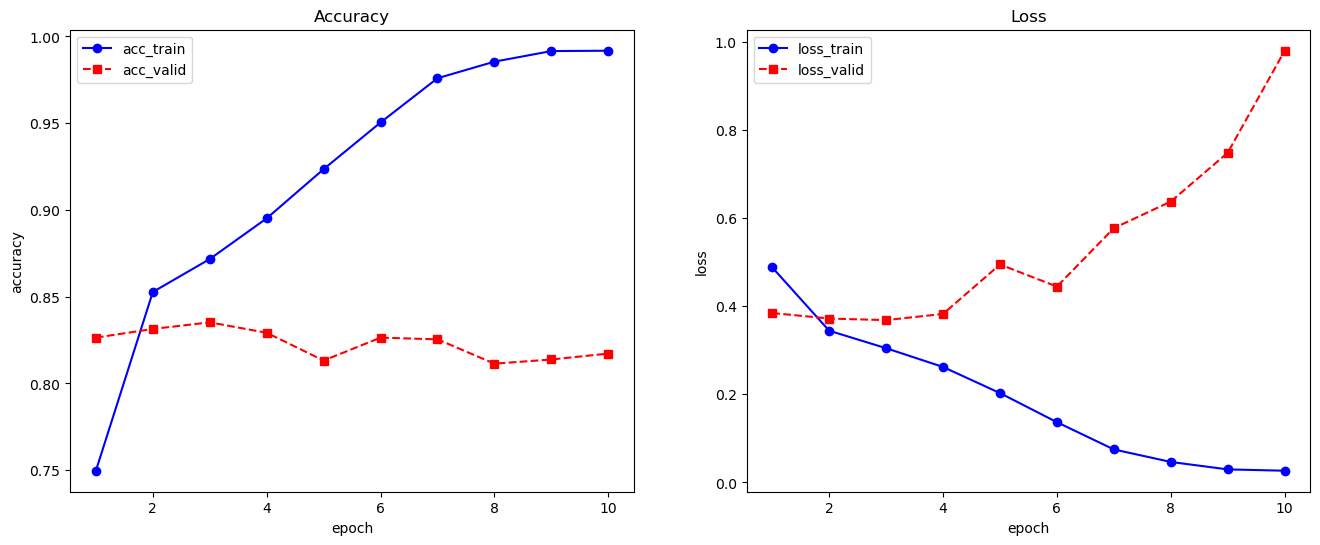

In [15]:
# 정확도, 손실 시각화
import matplotlib.pyplot as plt

epoch = np.arange(1, epochs + 1) # x축
acc_train = hist.history['accuracy'] # 트레이닝 데이터의 정확도를 저장한다.
loss_train = hist.history['loss'] # 트레이닝 데이터의 손실을 저장한다.
acc_valid = hist.history['val_accuracy'] # 벨리데이션 데이터의 정확도를 저장한다.
loss_valid = hist.history['val_loss'] # 벨리데이션 데이터의 손실을 저장한다.

plt.figure(figsize=(16, 6))
# 트레이닝 정확도, 벨리데이션 정확도 시각화
plt.subplot(1, 2, 1)
plt.plot(epoch, acc_train, 'b', marker='o', label='acc_train')
plt.plot(epoch, acc_valid, 'r--', marker='s', label='acc_valid')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epoch, loss_train, 'b', marker='o', label='loss_train')
plt.plot(epoch, loss_valid, 'r--', marker='s', label='loss_valid')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()